In [2]:
!nvidia-smi

Thu Oct  3 21:51:17 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060      WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   56C    P0             20W /  170W |     919MiB /  12288MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [93]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler

In [94]:
data_transforms = {
    'train' : transforms.Compose([
        transforms.RandomResizedCrop(150),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val' : transforms.Compose([
        transforms.Resize(150),
        transforms.CenterCrop(150),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

2. Load the Dataset

In [95]:
data_dir="D://Refund_Model//Data//train"
image_datasets={
    'train': datasets.ImageFolder(root=data_dir, transform=data_transforms['train']),
    'val': datasets.ImageFolder(root=data_dir, transform= data_transforms['val'])
}
#DataLoader- Load the data in batches
dataloaders={
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True),
    'val': DataLoader(image_datasets['val'], batch_size=32, shuffle=False)
}

3. Load the Pretrained VGG16 Model and Modify it for our Use Case

In [96]:
model= models.vgg16(pretrained=True)

# Freeze earlier layers
for param in model.features.parameters():
    param.requires_grad = False
# Unfreeze last 4 layers of the feature extractor
for param in model.features[-4:]:  
    param.requires_grad = True

#Modify the classifier to match the number of the output classes
model.classifier[6]=nn.Sequential(
    nn.Linear(4096,256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256,22)
    
    
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device} is being used.")
# Move the Model to GPU if avaliable
model = model.to(device)

cuda is being used.


4. Define Loss Function and Optimizer 

In [97]:
criterion= nn.CrossEntropyLoss()#Cross-entropy loss for multi-class classification
optimizer= optim.Adam(model.parameters(), lr=0.000001) #Adam optimizer with a low learning rate

In [98]:
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)  # Step scheduler

class EarlyStopping:
    def __init__(self, patience=3, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                print("Early stopping")
                self.early_stop = True


5. Training the Model 

In [99]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, early_stopping, num_epochs=15):
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc)
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc)

        # Step the learning rate scheduler
        scheduler.step()
        
        # Check early stopping
        early_stopping(history['val_loss'][-1])
        if early_stopping.early_stop:
            print("Stopping training early")
            break

    return history

# Initialize EarlyStopping
early_stopping = EarlyStopping(patience=3)

# Call the training function with scheduler and early stopping
history = train_model(model, dataloaders, criterion, optimizer, scheduler, early_stopping, num_epochs=15)

# Now you can monitor the history and plot it later if needed.

                  
            

Epoch 1/15
----------
train Loss: 2.7440 Acc: 0.2083
val Loss: 2.1250 Acc: 0.4617
Epoch 2/15
----------
train Loss: 2.2558 Acc: 0.3637
val Loss: 1.6788 Acc: 0.5729
Epoch 3/15
----------
train Loss: 2.0386 Acc: 0.4271
val Loss: 1.4563 Acc: 0.6213
Epoch 4/15
----------
train Loss: 1.9071 Acc: 0.4632
val Loss: 1.3339 Acc: 0.6485
Epoch 5/15
----------
train Loss: 1.8251 Acc: 0.4871
val Loss: 1.2670 Acc: 0.6625
Epoch 6/15
----------
train Loss: 1.7699 Acc: 0.5036
val Loss: 1.2225 Acc: 0.6713
Epoch 7/15
----------
train Loss: 1.7297 Acc: 0.5133
val Loss: 1.1899 Acc: 0.6789
Epoch 8/15
----------
train Loss: 1.7042 Acc: 0.5250
val Loss: 1.1877 Acc: 0.6792
Epoch 9/15
----------
train Loss: 1.7020 Acc: 0.5247
val Loss: 1.1857 Acc: 0.6798
Epoch 10/15
----------
train Loss: 1.6944 Acc: 0.5233
val Loss: 1.1829 Acc: 0.6801
Epoch 11/15
----------
train Loss: 1.6932 Acc: 0.5259
val Loss: 1.1808 Acc: 0.6806
Epoch 12/15
----------
train Loss: 1.6878 Acc: 0.5292
val Loss: 1.1781 Acc: 0.6811
Epoch 13/15
-

6. Save the Trained Model

In [100]:
torch.save(model.state_dict(),'final_refund_item_classifier.pth')

7. Plot Training History

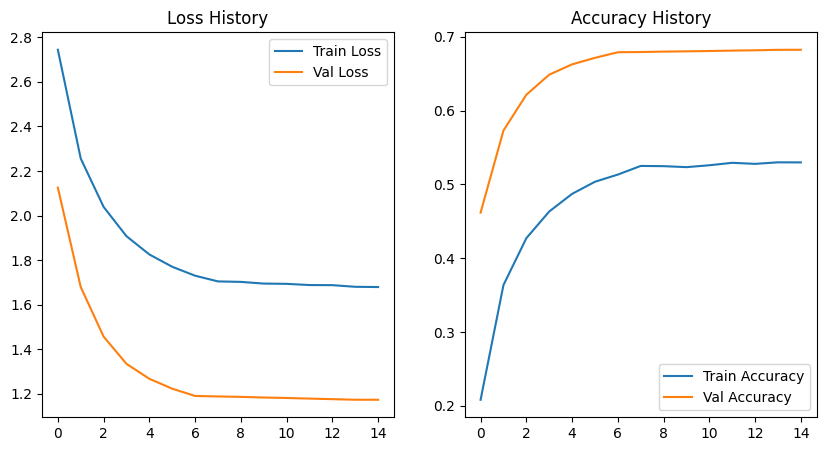

In [101]:
# Convert the tensors in history to CPU before plotting
train_acc_cpu = [acc.cpu().numpy() for acc in history['train_acc']]
val_acc_cpu = [acc.cpu().numpy() for acc in history['val_acc']]
train_loss_cpu = history['train_loss']  # Losses are typically on CPU, but you can verify
val_loss_cpu = history['val_loss']  # Same for validation loss

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(train_loss_cpu, label='Train Loss')
plt.plot(val_loss_cpu, label='Val Loss')
plt.title('Loss History')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_acc_cpu, label='Train Accuracy')
plt.plot(val_acc_cpu,label ='Val Accuracy')
plt.title('Accuracy History')
plt.legend()
plt.show()

8. Model Metrics

Accuracy: 0.6823
Precision (Weighted): 0.6902
Recall (Weighted): 0.6823
F1-Score (Weighted): 0.6777

Classification Report:
                            precision    recall  f1-score   support

                       AC       0.63      0.34      0.44      1824
            Baby Products       0.55      0.72      0.63      2677
          Bags & Handbags       0.64      0.43      0.51      5390
        Bathroom Fittings       0.61      0.37      0.46      2681
          Beauty Products       0.61      0.67      0.64      5257
                    Belts       0.61      0.54      0.57      2687
              Caps & Hats       0.79      0.52      0.63      2660
                 Clothing       0.90      0.93      0.92     17786
                Earphones       0.44      0.49      0.46      2682
                 Footwear       0.79      0.89      0.84      6923
                Furniture       0.72      0.49      0.58      5311
           Games & Sports       0.63      0.68      0.65      5300
   

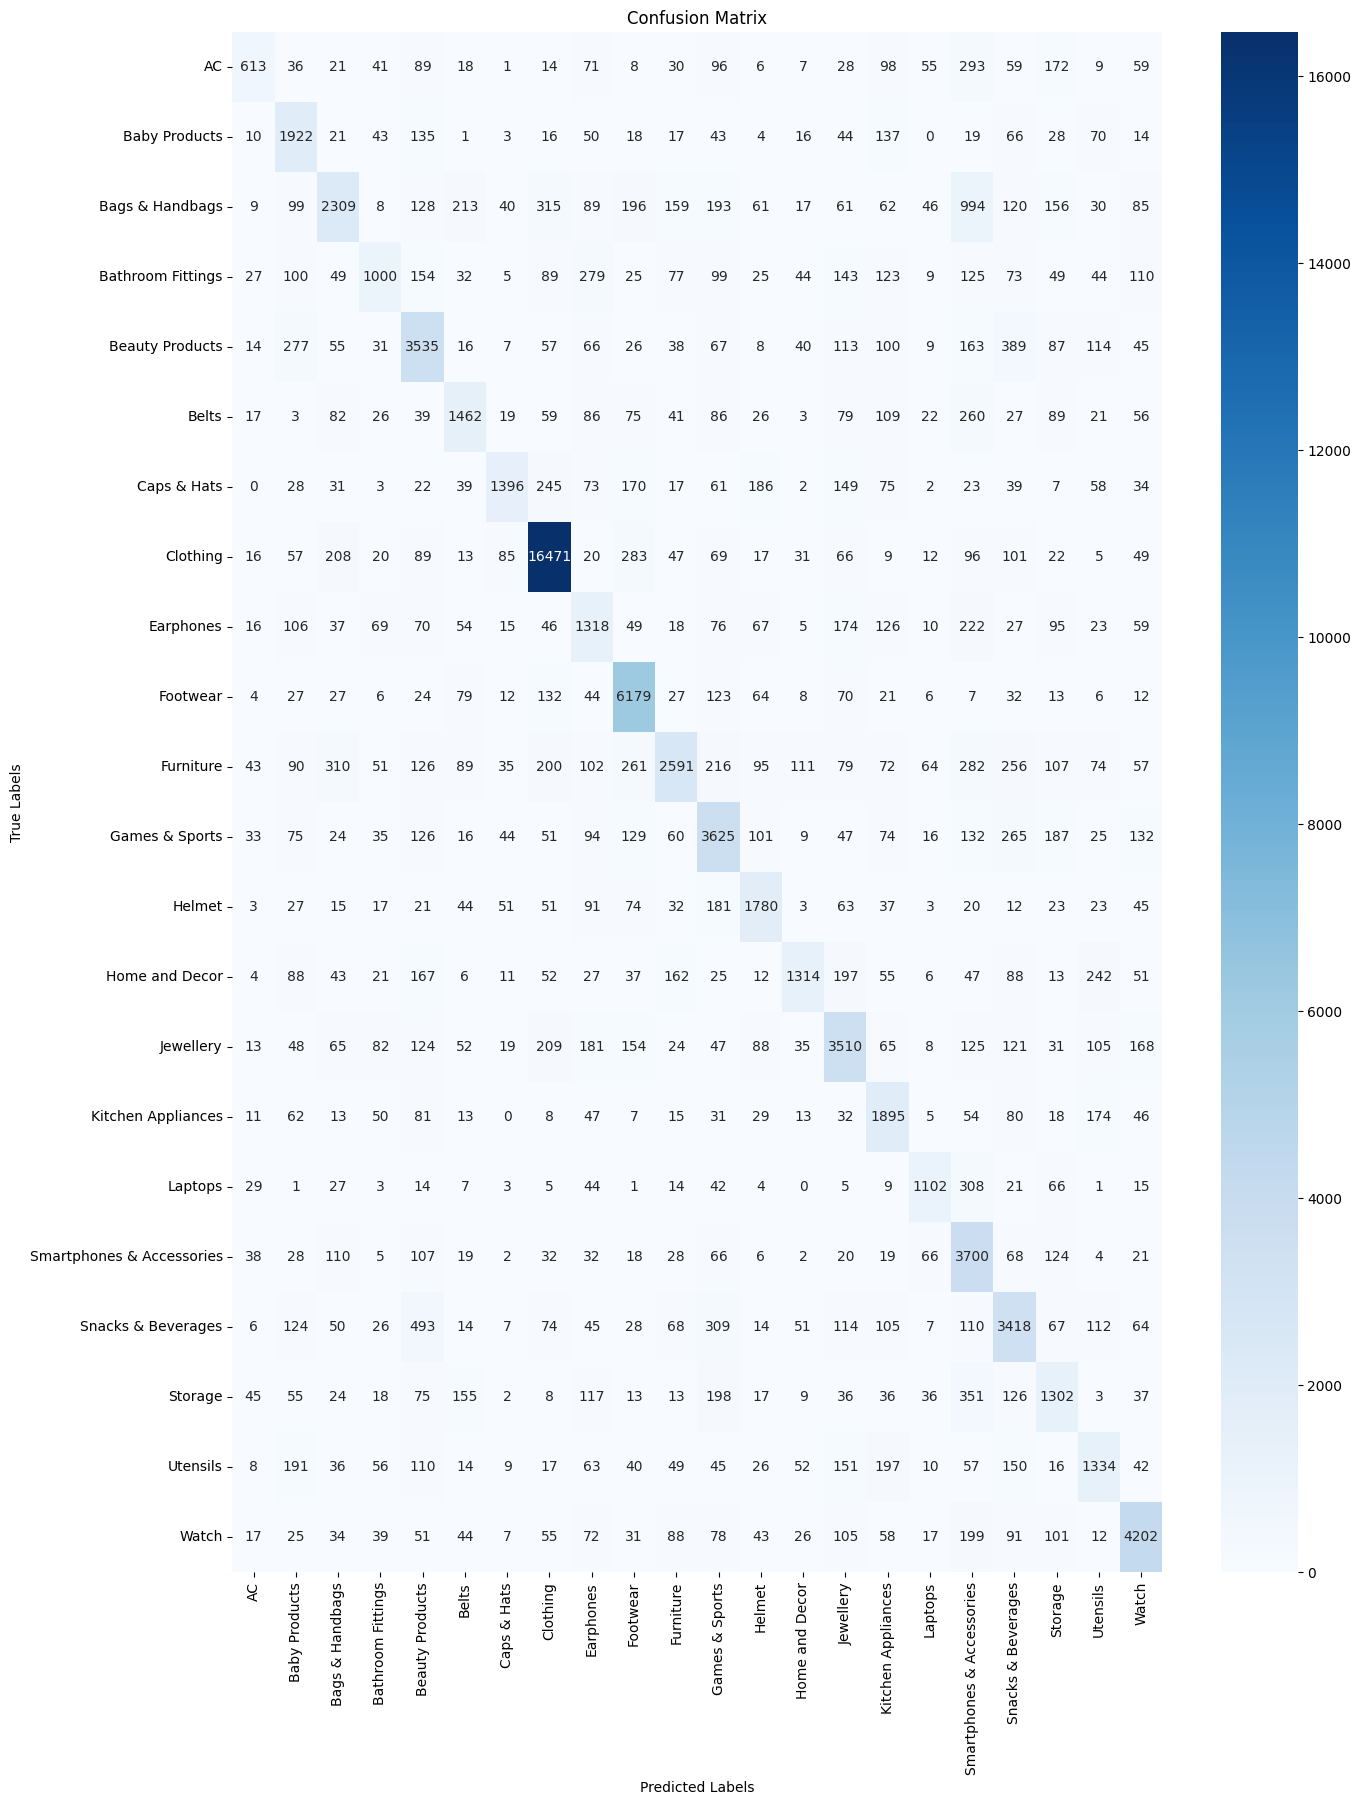

In [102]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Function to make predictions and compute the metrics
def compute_metrics(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []
    
    # No gradient calculation needed during evaluation
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Get predictions
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            # Store the predictions and actual labels
            all_preds.extend(preds.cpu().numpy())  # Move tensors to CPU and convert to numpy
            all_labels.extend(labels.cpu().numpy())
    
    # Compute accuracy, precision, recall, and F1-score
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    # Print classification report for a detailed breakdown
    class_names = image_datasets['train'].classes  # List of class names
    report = classification_report(all_labels, all_preds, target_names=class_names)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (Weighted): {precision:.4f}")
    print(f"Recall (Weighted): {recall:.4f}")
    print(f"F1-Score (Weighted): {f1:.4f}")
    print("\nClassification Report:\n", report)

# Call the function to compute and print metrics
compute_metrics(model, dataloaders['val'])
# Function to make predictions and compute the confusion matrix
def compute_confusion_matrix(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []
    
    # No gradient calculation needed during evaluation
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Get predictions
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            # Store the predictions and actual labels
            all_preds.extend(preds.cpu().numpy())  # Move tensors to CPU and convert to numpy
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    return cm

# Function to plot confusion matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(15,20))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# Call the function to compute and plot the confusion matrix
class_names = image_datasets['train'].classes  # List of class names (40 classes)
cm = compute_confusion_matrix(model, dataloaders['val'])
plot_confusion_matrix(cm, class_names)
